In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

csv_files = []
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for file in files:
        if file.lower().endswith('.csv'):
            csv_files.append(os.path.join(root, file))

csv_files


['/content/drive/MyDrive/COIN_hourly_1y_massive-1.csv',
 '/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv',
 '/content/drive/MyDrive/SPY_hourly_1y_massive.csv',
 '/content/drive/MyDrive/IWV_hourly_1y_massive.csv',
 '/content/drive/MyDrive/QQQ_hourly_1y_massive.csv',
 '/content/drive/MyDrive/btc_etf_model_interval_results.csv',
 '/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv']

In [12]:
def run_models_for_horizon(base_df, feature_cols, horizon_hours, threshold_window=50):
    """
    horizon_hours: how many hours ahead we look to compute the future return.
    Label = 1 if |H-hour log return| > rolling median(|H-hour log return|) over threshold_window.
    """

    print("\n" + "="*70)
    print(f"HORIZON = {horizon_hours} hours ahead")
    print("="*70)

    df_h = base_df.copy()

    # Future H-hour log return
    df_h["future_ret_H"] = np.log(df_h["close"].shift(-horizon_hours)) - np.log(df_h["close"])
    df_h["future_abs_ret_H"] = df_h["future_ret_H"].abs()

    # Rolling, time-local threshold for "large" move
    df_h["move_threshold_H"] = df_h["future_abs_ret_H"].rolling(threshold_window).median()

    # Binary target
    df_h["y_large_move"] = (df_h["future_abs_ret_H"] > df_h["move_threshold_H"]).astype(int)

    # Drop rows with NaNs from lags, vols, and future shift
    df_h = df_h.dropna(subset=feature_cols + ["y_large_move"])

    X = df_h[feature_cols]
    y = df_h["y_large_move"].astype(int)

    n = len(df_h)
    if n < 500:
        print(f"Not enough data for horizon {horizon_hours}h (n={n}), skipping.\n")
        return

    # If overall we only see one class, bail
    class_counts = y.value_counts().sort_index()
    print("Class balance (0=no large move, 1=large move):")
    for cls, cnt in class_counts.items():
        print(f"  class {cls}: {cnt} ({cnt/n:.1%})")

    if class_counts.shape[0] < 2:
        print(f"Only one class present for horizon {horizon_hours}h "
              f"({class_counts.index[0]}). Skipping this horizon.\n")
        return

    # Time-based split: Train / Val / Test using fractions (no shuffling)
    train_end = int(0.56 * n)
    val_end   = int(0.70 * n)

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]

    X_val   = X.iloc[train_end:val_end]
    y_val   = y.iloc[train_end:val_end]

    X_test  = X.iloc[val_end:]
    y_test  = y.iloc[val_end:]

    # Make sure train/test both have at least 2 classes
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        print(f"Not enough class variation in train/test for horizon {horizon_hours}h. "
              f"Skipping this horizon.\n")
        return

    print(f"Sample size: {n}")
    print(f"  Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

    # Convenience for printing metrics
    def eval_model(name, y_true, y_pred, y_proba=None):
        print("\n" + "-"*70)
        print(name)
        print("-"*70)
        acc = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {acc:.3%}")

        if y_proba is not None:
            try:
                auc = roc_auc_score(y_true, y_proba)
                print(f"ROC AUC: {auc:.4f}")
            except ValueError:
                print("ROC AUC: could not be computed (single class in y_true).")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))

    # ---- Logistic Regression ----
    logreg_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2", C=1.0, max_iter=2000,
            class_weight="balanced", solver="lbfgs"
        )),
    ])
    logreg_pipe.fit(X_train, y_train)
    y_pred_lr  = logreg_pipe.predict(X_test)
    y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]
    eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)

    coef = pd.Series(
        logreg_pipe.named_steps["logreg"].coef_[0],
        index=feature_cols
    ).sort_values(key=np.abs, ascending=False)
    print("\nLogistic Regression Coefficients (sorted by |value|):")
    print(coef)

    # ---- Random Forest ----
    rf = RandomForestClassifier(
        n_estimators=500, max_depth=6,
        min_samples_leaf=20, max_features="sqrt",
        n_jobs=-1, random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred_rf  = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:, 1]
    eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
    imp_rf = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(imp_rf)

    # ---- Gradient Boosting ----
    gb = GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05,
        max_depth=3, subsample=0.8, random_state=42
    )
    gb.fit(X_train, y_train)
    y_pred_gb  = gb.predict(X_test)
    y_proba_gb = gb.predict_proba(X_test)[:, 1]
    eval_model("GradientBoosting (sklearn)", y_test, y_pred_gb, y_proba_gb)

    # ---- XGBoost ----
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = 1.0 if pos == 0 else neg / pos

    base_xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": 42,
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight,
        "use_label_encoder": False,
    }

    param_grid = [
        {"n_estimators": 400, "max_depth": 3, "learning_rate": 0.05,
         "subsample": 0.8, "colsample_bytree": 0.8, "gamma": 0.0, "reg_lambda": 1.0},
        {"n_estimators": 600, "max_depth": 4, "learning_rate": 0.03,
         "subsample": 0.8, "colsample_bytree": 0.9, "gamma": 0.0, "reg_lambda": 1.0},
        {"n_estimators": 800, "max_depth": 5, "learning_rate": 0.02,
         "subsample": 0.9, "colsample_bytree": 0.9, "gamma": 0.1, "reg_lambda": 2.0},
    ]

    print("\nStarting simple time-based tuning over XGB param sets (eval on validation split)...")
    best_auc = -np.inf
    best_params = None

    for i, p in enumerate(param_grid, start=1):
        params = base_xgb_params.copy()
        params.update(p)
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        val_proba = model.predict_proba(X_val)[:, 1]
        try:
            val_auc = roc_auc_score(y_val, val_proba)
        except ValueError:
            val_auc = np.nan
        print(f"  Model {i} val AUC: {val_auc:.4f} with params: {p}")
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params

    print("\nBest XGB val AUC: {:.4f} with params:".format(best_auc))
    print(best_params)

    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val])

    best_xgb = xgb.XGBClassifier(**best_params)
    best_xgb.fit(X_trainval, y_trainval, verbose=False)
    y_pred_xgb  = best_xgb.predict(X_test)
    y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
    eval_model("XGBoost (Best tuned on val, refit on Train+Val)", y_test, y_pred_xgb, y_proba_xgb)

    imp_xgb = pd.Series(best_xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nXGBoost Feature Importances:")
    print(imp_xgb)

    # ---- ANN ----
    ann_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(32, 16),
            activation="relu",
            solver="adam",
            alpha=1e-3,
            batch_size=64,
            learning_rate="adaptive",
            max_iter=300,
            random_state=42,
            shuffle=False,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.1,
        )),
    ])
    ann_pipe.fit(X_train, y_train)
    y_pred_ann  = ann_pipe.predict(X_test)
    y_proba_ann = ann_pipe.predict_proba(X_test)[:, 1]
    eval_model("ANN (MLPClassifier, scaled features)", y_test, y_pred_ann, y_proba_ann)

    print("\nDone for horizon {} hours.".format(horizon_hours))


In [14]:

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# ============================================================
# 1. File paths
# ============================================================
coin_path = "/content/drive/MyDrive/COIN_hourly_1y_massive-1.csv"
btc_path  = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"

# ============================================================
# 2. Load COIN hourly (window_start → datetime index)
# ============================================================
coin = pd.read_csv(coin_path)

# COIN already has a proper datetime column
coin["window_start"] = pd.to_datetime(coin["window_start"], utc=True)
coin = coin.set_index("window_start").sort_index()

# keep only close as 'close'
coin = coin.rename(columns={"close": "close"})[["close"]]

print("COIN hourly range:")
print(" ", coin.index.min(), "→", coin.index.max(), "| n =", len(coin))

# ============================================================
# 3. Load BTC 1-min, convert to hourly (FIXED: unit='s')
# ============================================================
btc = pd.read_csv(btc_path)
print("\nBTC columns:", list(btc.columns))

# --- detect timestamp column ---
if "timestamp" in btc.columns:
    btc_time_col = "timestamp"
else:
    btc_time_col = None
    for col in btc.columns:
        if "time" in col.lower() or "date" in col.lower():
            btc_time_col = col
            break

if btc_time_col is None:
    raise SystemExit("Could not find a time column in BTC file.")

# --- detect close column ---
if "close" in btc.columns:
    btc_close_col = "close"
elif "Close" in btc.columns:
    btc_close_col = "Close"
elif "c" in btc.columns:
    btc_close_col = "c"
else:
    raise SystemExit(f"Could not find a close column in BTC file. Columns: {list(btc.columns)}")

print("Using BTC time column:", btc_time_col)
print("Using BTC close column:", btc_close_col)

# Check if timestamp is numeric → treat as Unix seconds
if np.issubdtype(btc[btc_time_col].dtype, np.number):
    btc[btc_time_col] = pd.to_datetime(btc[btc_time_col], unit="s", utc=True)
else:
    btc[btc_time_col] = pd.to_datetime(btc[btc_time_col], utc=True)

btc = btc.set_index(btc_time_col).sort_index()

# resample to hourly (use '1h' to avoid deprecation)
btc_hourly = btc[btc_close_col].resample("1h").last().to_frame("btc_close")

print("\nBTC hourly range:")
print(" ", btc_hourly.index.min(), "→", btc_hourly.index.max(), "| n =", len(btc_hourly))

# ============================================================
# 4. Align overlapping window
# ============================================================
overlap_start = max(coin.index.min(), btc_hourly.index.min())
overlap_end   = min(coin.index.max(), btc_hourly.index.max())

print("\nOverlap window:")
print("  overlap_start:", overlap_start)
print("  overlap_end  :", overlap_end)

if overlap_start >= overlap_end:
    raise SystemExit("No overlapping time window – check BTC timestamp parsing or date ranges.")

coin_c = coin.loc[overlap_start:overlap_end]
btc_c  = btc_hourly.loc[overlap_start:overlap_end]

merged_mkt = coin_c.join(btc_c, how="inner")

print("\nmerged_mkt info:")
print(merged_mkt.info())
print(merged_mkt.head())
print("\nmerged_mkt rows:", len(merged_mkt))

if len(merged_mkt) < 600:
    raise SystemExit("merged_mkt has too few rows after overlap crop – need more overlapping history.")

# ============================================================
# 5. Feature engineering
# ============================================================
df = merged_mkt.copy().sort_index()

df["coin_ret_1h"] = np.log(df["close"]) - np.log(df["close"].shift(1))


COIN hourly range:
  2024-12-09 09:00:00+00:00 → 2025-12-06 00:00:00+00:00 | n = 3969

BTC columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'datetime']
Using BTC time column: timestamp
Using BTC close column: close

BTC hourly range:
  2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00 | n = 8761

Overlap window:
  overlap_start: 2024-12-09 09:00:00+00:00
  overlap_end  : 2025-12-06 00:00:00+00:00

merged_mkt info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3969 entries, 2024-12-09 09:00:00+00:00 to 2025-12-06 00:00:00+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      3969 non-null   float64
 1   btc_close  3969 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 93.0 KB
None
                            close  btc_close
2024-12-09 09:00:00+00:00  334.68      98423
2024-12-09 10:00:00+00:00  337.01      98710
2024-12-09 11:00:00+00:00  335.91      98066
2024-12-09 1

In [15]:
# ============================================
# Multi-horizon classification for large moves
# Models: LogReg, RF, GB, XGB (tuned), ANN
# Horizons (hours ahead): [1, 3, 6, 12, 24]
# ============================================

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb

# ----------------------------------------------------
# 1. Base feature engineering (same as your 1h setup)
# ----------------------------------------------------
# assumes merged_mkt already defined from your earlier cell
df = merged_mkt.copy().sort_index()  # ensure time order

# Hourly returns
df["coin_ret_1h"] = np.log(df["close"]) - np.log(df["close"].shift(1))
df["btc_ret_1h"]  = np.log(df["btc_close"]) - np.log(df["btc_close"].shift(1))

# Lags
df["coin_ret_lag_1"] = df["coin_ret_1h"].shift(1)
df["coin_ret_lag_2"] = df["coin_ret_1h"].shift(2)
df["coin_ret_lag_3"] = df["coin_ret_1h"].shift(3)

df["btc_ret_lag_1"] = df["btc_ret_1h"].shift(1)
df["btc_ret_lag_2"] = df["btc_ret_1h"].shift(2)

# 6h rolling vols
df["coin_vol_6h"] = df["coin_ret_1h"].rolling(6).std()
df["btc_vol_6h"]  = df["btc_ret_1h"].rolling(6).std()

# Spread
df["coin_minus_btc"] = df["coin_ret_1h"] - df["btc_ret_1h"]

feature_cols = [
    "coin_ret_1h",
    "coin_ret_lag_1",
    "coin_ret_lag_2",
    "coin_ret_lag_3",
    "btc_ret_1h",
    "btc_ret_lag_1",
    "btc_ret_lag_2",
    "coin_vol_6h",
    "btc_vol_6h",
    "coin_minus_btc",
]

print("Feature DF shape:", df.shape)
print("Feature columns:", feature_cols)

# ----------------------------------------------------
# 2. Helper: evaluate all models for a given horizon H
# ----------------------------------------------------
def run_models_for_horizon(base_df, feature_cols, horizon_hours, threshold_window=50):
    """
    horizon_hours: how many hours ahead we look to compute the future return.
    Label = 1 if |H-hour log return| > rolling median(|H-hour log return|) over threshold_window.
    """

    print("\n" + "=" * 70)
    print(f"HORIZON = {horizon_hours} hours ahead")
    print("=" * 70)

    df_h = base_df.copy()

    # Future H-hour log return
    df_h["future_ret_H"] = np.log(df_h["close"].shift(-horizon_hours)) - np.log(df_h["close"])
    df_h["future_abs_ret_H"] = df_h["future_ret_H"].abs()

    # Rolling, time-local threshold for "large" move
    df_h["move_threshold_H"] = df_h["future_abs_ret_H"].rolling(threshold_window).median()

    # Binary target
    df_h["y_large_move"] = (df_h["future_abs_ret_H"] > df_h["move_threshold_H"]).astype(int)

    # Drop rows with NaNs from lags, vols, and future shift
    df_h = df_h.dropna(subset=feature_cols + ["y_large_move"])

    X = df_h[feature_cols]
    y = df_h["y_large_move"].astype(int)

    n = len(df_h)
    if n < 500:
        print(f"Not enough data for horizon {horizon_hours}h (n={n}), skipping.\n")
        return

    # Class balance in full sample
    class_counts = y.value_counts().sort_index()
    print("Class balance in full sample (0=no large move, 1=large move):")
    for cls, cnt in class_counts.items():
        print(f"  class {cls}: {cnt} ({cnt / n:.1%})")

    # If overall we only see one class, bail
    if class_counts.shape[0] < 2:
        print(f"Only one class present for horizon {horizon_hours}h "
              f"({class_counts.index[0]}). Skipping this horizon.\n")
        return

    # Time-based split: Train / Val / Test using fractions (no shuffling)
    train_end = int(0.56 * n)
    val_end   = int(0.70 * n)

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]

    X_val   = X.iloc[train_end:val_end]
    y_val   = y.iloc[train_end:val_end]

    X_test  = X.iloc[val_end:]
    y_test  = y.iloc[val_end:]

    # Make sure train/test both have at least 2 classes
    if y_train.nunique() < 2 or y_test.nunique() < 2:
        print(f"Not enough class variation in train/test for horizon {horizon_hours}h. "
              f"Skipping this horizon.\n")
        return

    print(f"Sample size: {n}")
    print(f"  Train: {len(X_train)}  | Val: {len(X_val)}  | Test: {len(X_test)}")

    # Convenience for printing metrics
    def eval_model(name, y_true, y_pred, y_proba=None):
        print("\n" + "-" * 70)
        print(name)
        print("-" * 70)
        acc = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {acc:.3%}")

        if y_proba is not None:
            try:
                auc = roc_auc_score(y_true, y_proba)
                print(f"ROC AUC: {auc:.4f}")
            except ValueError:
                print("ROC AUC: could not be computed (single class in y_true).")
        else:
            print("ROC AUC: (not computed – no predicted probabilities)")

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true, y_pred))

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))

    # ------------------------------------------------
    # 2.1 Logistic Regression (with scaling)
    # ------------------------------------------------
    logreg_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2",
            C=1.0,
            max_iter=2000,
            class_weight="balanced",
            solver="lbfgs"
        )),
    ])

    logreg_pipe.fit(X_train, y_train)
    y_pred_lr  = logreg_pipe.predict(X_test)
    y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

    eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)

    # Coefficients (on scaled features)
    coef = pd.Series(
        logreg_pipe.named_steps["logreg"].coef_[0],
        index=feature_cols
    ).sort_values(key=np.abs, ascending=False)

    print("\nLogistic Regression Coefficients (sorted by |value|):")
    print(coef)

    # ------------------------------------------------
    # 2.2 Random Forest
    # ------------------------------------------------
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        min_samples_leaf=20,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    y_pred_rf  = rf.predict(X_test)
    y_proba_rf = rf.predict_proba(X_test)[:, 1]

    eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf)

    imp_rf = pd.Series(
        rf.feature_importances_,
        index=feature_cols
    ).sort_values(ascending=False)

    print("\nRandom Forest Feature Importances:")
    print(imp_rf)

    # ------------------------------------------------
    # 2.3 Gradient Boosting (sklearn)
    # ------------------------------------------------
    gb = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    )

    gb.fit(X_train, y_train)
    y_pred_gb  = gb.predict(X_test)
    y_proba_gb = gb.predict_proba(X_test)[:, 1]

    eval_model("GradientBoosting (sklearn)", y_test, y_pred_gb, y_proba_gb)

    # ------------------------------------------------
    # 2.4 XGBoost with small time-based hyperparam sweep
    # ------------------------------------------------
    # Scale_pos_weight to handle any mild imbalance
    pos = y_train.sum()
    neg = len(y_train) - pos
    if pos == 0:
        scale_pos_weight = 1.0
    else:
        scale_pos_weight = neg / pos

    base_xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": 42,
        "tree_method": "hist",
        "scale_pos_weight": scale_pos_weight,
        "use_label_encoder": False,
    }

    param_grid = [
        {
            "n_estimators": 400,
            "max_depth": 3,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "gamma": 0.0,
            "reg_lambda": 1.0,
        },
        {
            "n_estimators": 600,
            "max_depth": 4,
            "learning_rate": 0.03,
            "subsample": 0.8,
            "colsample_bytree": 0.9,
            "gamma": 0.0,
            "reg_lambda": 1.0,
        },
        {
            "n_estimators": 800,
            "max_depth": 5,
            "learning_rate": 0.02,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "gamma": 0.1,
            "reg_lambda": 2.0,
        },
    ]

    print("\nStarting simple time-based tuning over XGB param sets (eval on validation split)...")

    best_auc = -np.inf
    best_params = None
    best_model  = None

    for i, p in enumerate(param_grid, start=1):
        params = base_xgb_params.copy()
        params.update(p)

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        # Evaluate on validation set
        val_proba = model.predict_proba(X_val)[:, 1]
        try:
            val_auc = roc_auc_score(y_val, val_proba)
        except ValueError:
            val_auc = np.nan

        print(f"  Model {i} val AUC: {val_auc:.4f} with params: {p}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params
            best_model = model

    print("\nBest XGB val AUC: {:.4f} with params:".format(best_auc))
    print(best_params)

    # Refit XGB on Train+Val with best params
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val])

    best_xgb = xgb.XGBClassifier(**best_params)
    best_xgb.fit(X_trainval, y_trainval, verbose=False)

    y_pred_xgb  = best_xgb.predict(X_test)
    y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

    eval_model("XGBoost (Best tuned on val, refit on Train+Val)", y_test, y_pred_xgb, y_proba_xgb)

    imp_xgb = pd.Series(
        best_xgb.feature_importances_,
        index=feature_cols
    ).sort_values(ascending=False)

    print("\nXGBoost Feature Importances:")
    print(imp_xgb)

    # ------------------------------------------------
    # 2.5 ANN (MLPClassifier) with scaling, no shuffling
    # ------------------------------------------------
    ann_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(32, 16),
            activation="relu",
            solver="adam",
            alpha=1e-3,
            batch_size=64,
            learning_rate="adaptive",
            max_iter=300,
            random_state=42,
            shuffle=False,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.1,
        )),
    ])

    ann_pipe.fit(X_train, y_train)
    y_pred_ann  = ann_pipe.predict(X_test)
    y_proba_ann = ann_pipe.predict_proba(X_test)[:, 1]

    eval_model("ANN (MLPClassifier, scaled features)", y_test, y_pred_ann, y_proba_ann)

    print("\nDone for horizon {} hours.".format(horizon_hours))


# ----------------------------------------------------
# 3. Run for multiple horizons (in HOURS)
# ----------------------------------------------------
horizons = [1, 3, 6, 12, 24]

for H in horizons:
    run_models_for_horizon(df, feature_cols, horizon_hours=H, threshold_window=50)


Feature DF shape: (3969, 12)
Feature columns: ['coin_ret_1h', 'coin_ret_lag_1', 'coin_ret_lag_2', 'coin_ret_lag_3', 'btc_ret_1h', 'btc_ret_lag_1', 'btc_ret_lag_2', 'coin_vol_6h', 'btc_vol_6h', 'coin_minus_btc']

HORIZON = 1 hours ahead
Class balance in full sample (0=no large move, 1=large move):
  class 0: 1993 (50.3%)
  class 1: 1970 (49.7%)
Sample size: 3963
  Train: 2219  | Val: 555  | Test: 1189

----------------------------------------------------------------------
Logistic Regression
----------------------------------------------------------------------
Accuracy: 53.154%
ROC AUC: 0.5453

Confusion Matrix:
[[391 208]
 [349 241]]

Classification Report:
              precision    recall  f1-score   support

           0      0.528     0.653     0.584       599
           1      0.537     0.408     0.464       590

    accuracy                          0.532      1189
   macro avg      0.533     0.531     0.524      1189
weighted avg      0.533     0.532     0.524      1189


Logis

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 1 val AUC: 0.5489 with params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 2 val AUC: 0.5408 with params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 3 val AUC: 0.5398 with params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}

Best XGB val AUC: 0.5489 with params:
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 42, 'tree_method': 'hist', 'scale_pos_weight': np.float64(1.0264840182648403), 'use_label_encoder': False, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----------------------------------------------------------------------
XGBoost (Best tuned on val, refit on Train+Val)
----------------------------------------------------------------------
Accuracy: 55.677%
ROC AUC: 0.5509

Confusion Matrix:
[[362 237]
 [290 300]]

Classification Report:
              precision    recall  f1-score   support

           0      0.555     0.604     0.579       599
           1      0.559     0.508     0.532       590

    accuracy                          0.557      1189
   macro avg      0.557     0.556     0.556      1189
weighted avg      0.557     0.557     0.556      1189


XGBoost Feature Importances:
coin_ret_1h       0.110355
coin_ret_lag_1    0.105903
coin_minus_btc    0.105038
btc_ret_lag_1     0.099697
coin_ret_lag_2    0.099425
coin_ret_lag_3    0.098973
coin_vol_6h       0.097132
btc_ret_1h        0.096753
btc_ret_lag_2     0.093582
btc_vol_6h        0.093143
dtype: float32

------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 1 val AUC: 0.5150 with params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 2 val AUC: 0.5154 with params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 3 val AUC: 0.5198 with params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}

Best XGB val AUC: 0.5198 with params:
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 42, 'tree_method': 'hist', 'scale_pos_weight': np.float64(1.0283363802559415), 'use_label_encoder': False, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----------------------------------------------------------------------
XGBoost (Best tuned on val, refit on Train+Val)
----------------------------------------------------------------------
Accuracy: 49.537%
ROC AUC: 0.5084

Confusion Matrix:
[[294 315]
 [285 295]]

Classification Report:
              precision    recall  f1-score   support

           0      0.508     0.483     0.495       609
           1      0.484     0.509     0.496       580

    accuracy                          0.495      1189
   macro avg      0.496     0.496     0.495      1189
weighted avg      0.496     0.495     0.495      1189


XGBoost Feature Importances:
coin_vol_6h       0.106580
btc_vol_6h        0.106569
btc_ret_1h        0.104782
coin_minus_btc    0.102955
coin_ret_1h       0.100416
btc_ret_lag_1     0.099593
coin_ret_lag_1    0.098777
btc_ret_lag_2     0.094040
coin_ret_lag_3    0.093312
coin_ret_lag_2    0.092976
dtype: float32

------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 1 val AUC: 0.5611 with params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 2 val AUC: 0.5612 with params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 3 val AUC: 0.5633 with params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}

Best XGB val AUC: 0.5633 with params:
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 42, 'tree_method': 'hist', 'scale_pos_weight': np.float64(1.0376492194674012), 'use_label_encoder': False, 'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----------------------------------------------------------------------
XGBoost (Best tuned on val, refit on Train+Val)
----------------------------------------------------------------------
Accuracy: 51.724%
ROC AUC: 0.5228

Confusion Matrix:
[[313 317]
 [257 302]]

Classification Report:
              precision    recall  f1-score   support

           0      0.549     0.497     0.522       630
           1      0.488     0.540     0.513       559

    accuracy                          0.517      1189
   macro avg      0.519     0.519     0.517      1189
weighted avg      0.520     0.517     0.517      1189


XGBoost Feature Importances:
coin_vol_6h       0.113841
btc_vol_6h        0.111843
btc_ret_1h        0.100716
coin_minus_btc    0.099300
btc_ret_lag_2     0.097592
coin_ret_lag_3    0.096519
coin_ret_lag_1    0.096409
coin_ret_1h       0.096010
btc_ret_lag_1     0.094393
coin_ret_lag_2    0.093376
dtype: float32

------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 1 val AUC: 0.5654 with params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 2 val AUC: 0.5664 with params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 3 val AUC: 0.5569 with params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}

Best XGB val AUC: 0.5664 with params:
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 42, 'tree_method': 'hist', 'scale_pos_weight': np.float64(1.0283363802559415), 'use_label_encoder': False, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----------------------------------------------------------------------
XGBoost (Best tuned on val, refit on Train+Val)
----------------------------------------------------------------------
Accuracy: 51.220%
ROC AUC: 0.5196

Confusion Matrix:
[[301 306]
 [274 308]]

Classification Report:
              precision    recall  f1-score   support

           0      0.523     0.496     0.509       607
           1      0.502     0.529     0.515       582

    accuracy                          0.512      1189
   macro avg      0.513     0.513     0.512      1189
weighted avg      0.513     0.512     0.512      1189


XGBoost Feature Importances:
btc_vol_6h        0.121744
coin_vol_6h       0.109760
coin_ret_1h       0.099496
coin_minus_btc    0.099311
coin_ret_lag_1    0.098230
btc_ret_lag_1     0.097262
coin_ret_lag_2    0.094144
btc_ret_lag_2     0.093503
coin_ret_lag_3    0.093318
btc_ret_1h        0.093231
dtype: float32

------------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 1 val AUC: 0.5591 with params: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 2 val AUC: 0.5398 with params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Model 3 val AUC: 0.5418 with params: {'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.02, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'reg_lambda': 2.0}

Best XGB val AUC: 0.5591 with params:
{'objective': 'binary:logistic', 'eval_metric': 'auc', 'random_state': 42, 'tree_method': 'hist', 'scale_pos_weight': np.float64(1.0757717492984098), 'use_label_encoder': False, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.0, 'reg_lambda': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:04:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----------------------------------------------------------------------
XGBoost (Best tuned on val, refit on Train+Val)
----------------------------------------------------------------------
Accuracy: 52.061%
ROC AUC: 0.5307

Confusion Matrix:
[[307 317]
 [253 312]]

Classification Report:
              precision    recall  f1-score   support

           0      0.548     0.492     0.519       624
           1      0.496     0.552     0.523       565

    accuracy                          0.521      1189
   macro avg      0.522     0.522     0.521      1189
weighted avg      0.523     0.521     0.520      1189


XGBoost Feature Importances:
coin_vol_6h       0.119139
btc_vol_6h        0.114231
coin_ret_1h       0.105602
coin_minus_btc    0.101915
coin_ret_lag_2    0.097296
coin_ret_lag_1    0.096829
btc_ret_lag_2     0.095814
coin_ret_lag_3    0.092212
btc_ret_lag_1     0.091205
btc_ret_1h        0.085757
dtype: float32

------------------------------------------------------------------

In [16]:
# ===========================================================
# Evaluate XGB performance vs amount of historical data used
# Windows tested: 1m, 3m, 6m, 12m
# ===========================================================

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# -----------------------------------------------
# 1. Create full feature dataframe (same as before)
# -----------------------------------------------
df_full = merged_mkt.copy()

df_full["coin_ret_1h"] = np.log(df_full["close"]) - np.log(df_full["close"].shift(1))
df_full["btc_ret_1h"]  = np.log(df_full["btc_close"]) - np.log(df_full["btc_close"].shift(1))

df_full["coin_ret_lag_1"] = df_full["coin_ret_1h"].shift(1)
df_full["coin_ret_lag_2"] = df_full["coin_ret_1h"].shift(2)
df_full["coin_ret_lag_3"] = df_full["coin_ret_1h"].shift(3)

df_full["btc_ret_lag_1"] = df_full["btc_ret_1h"].shift(1)
df_full["btc_ret_lag_2"] = df_full["btc_ret_1h"].shift(2)

df_full["coin_vol_6h"] = df_full["coin_ret_1h"].rolling(6).std()
df_full["btc_vol_6h"]  = df_full["btc_ret_1h"].rolling(6).std()

df_full["coin_minus_btc"] = df_full["coin_ret_1h"] - df_full["btc_ret_1h"]

df_full = df_full.dropna()

# -----------------------------------------------
# 2. Build FUTURE 1-hour LARGE MOVE target (same as before)
# -----------------------------------------------
future_ret = np.log(df_full["close"].shift(-1)) - np.log(df_full["close"])
df_full["future_abs"] = future_ret.abs()
df_full["threshold"] = df_full["future_abs"].rolling(50).median()
df_full["y"] = (df_full["future_abs"] > df_full["threshold"]).astype(int)

df_full = df_full.dropna(subset=["y"])

# -----------------------------------------------
# 3. Define history windows
# -----------------------------------------------
history_windows = {
    "1_month":   24 * 30,
    "3_months":  24 * 90,
    "6_months":  24 * 180,
    "12_months": 24 * 365,
}

results = []

# choose the *final* 500 hours as test set
TEST_SIZE = 500
df_test = df_full.iloc[-TEST_SIZE:]
X_test = df_test[feature_cols]
y_test = df_test["y"]

# -----------------------------------------------
# 4. Train & evaluate XGB on different history sizes
# -----------------------------------------------
for label, hours in history_windows.items():

    df_train = df_full.iloc[-(TEST_SIZE + hours):-TEST_SIZE]

    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = neg / pos if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "scale_pos_weight": spw,
        "n_estimators": 400,
        "max_depth": 3,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    results.append([label, hours, acc, auc])

# -----------------------------------------------
# 5. Display results
# -----------------------------------------------
results_df = pd.DataFrame(results,
                          columns=["History Window", "Hours Used", "Accuracy", "ROC AUC"])

print("\n===== XGB PERFORMANCE VS HISTORY WINDOW =====\n")
print(results_df)



===== XGB PERFORMANCE VS HISTORY WINDOW =====

  History Window  Hours Used  Accuracy   ROC AUC
0        1_month         720     0.540  0.563345
1       3_months        2160     0.526  0.558988
2       6_months        4320     0.550  0.549186
3      12_months        8760     0.550  0.549186


===== XGB PERFORMANCE VS HISTORY WINDOW =====
  History Window  Hours Used (actual)  Accuracy   ROC AUC
0             1m                  720     0.540  0.563345
1             3m                 2160     0.526  0.558988
2             6m                 3463     0.550  0.549186
3             9m                 3463     0.550  0.549186
4            12m                 3463     0.550  0.549186


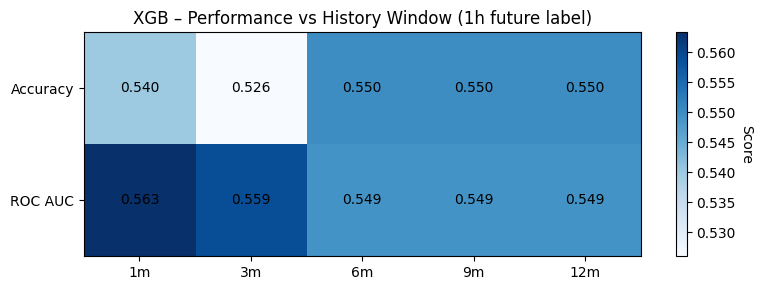

In [17]:
# ============================================
# XGB performance vs history length
# Windows: 1m, 3m, 6m, 9m, 12m  (hours-based)
# ============================================
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# 1) Build full feature DF from merged_mkt
df_full = merged_mkt.copy().sort_index()

# Features (same as earlier)
df_full["coin_ret_1h"] = np.log(df_full["close"]) - np.log(df_full["close"].shift(1))
df_full["btc_ret_1h"]  = np.log(df_full["btc_close"]) - np.log(df_full["btc_close"].shift(1))

df_full["coin_ret_lag_1"] = df_full["coin_ret_1h"].shift(1)
df_full["coin_ret_lag_2"] = df_full["coin_ret_1h"].shift(2)
df_full["coin_ret_lag_3"] = df_full["coin_ret_1h"].shift(3)

df_full["btc_ret_lag_1"] = df_full["btc_ret_1h"].shift(1)
df_full["btc_ret_lag_2"] = df_full["btc_ret_1h"].shift(2)

df_full["coin_vol_6h"] = df_full["coin_ret_1h"].rolling(6).std()
df_full["btc_vol_6h"]  = df_full["btc_ret_1h"].rolling(6).std()

df_full["coin_minus_btc"] = df_full["coin_ret_1h"] - df_full["btc_ret_1h"]

feature_cols = [
    "coin_ret_1h",
    "coin_ret_lag_1",
    "coin_ret_lag_2",
    "coin_ret_lag_3",
    "btc_ret_1h",
    "btc_ret_lag_1",
    "btc_ret_lag_2",
    "coin_vol_6h",
    "btc_vol_6h",
    "coin_minus_btc",
]

# Drop initial NaNs from lags/vols
df_full = df_full.dropna(subset=feature_cols)

# 2) Build 1-hour *future* "large move" label
future_ret = np.log(df_full["close"].shift(-1)) - np.log(df_full["close"])
df_full["future_abs"] = future_ret.abs()
df_full["threshold"]  = df_full["future_abs"].rolling(50).median()
df_full["y"] = (df_full["future_abs"] > df_full["threshold"]).astype(int)

df_full = df_full.dropna(subset=["y"])

# 3) Define history windows in HOURS
history_windows = {
    "1m":  24 * 30,
    "3m":  24 * 90,
    "6m":  24 * 180,
    "9m":  24 * 270,
    "12m": 24 * 365,   # effectively "all available" if we don't have full 12m
}

results = []

# last 500 hours = fixed test set
TEST_SIZE = 500
df_test = df_full.iloc[-TEST_SIZE:]
X_test  = df_test[feature_cols]
y_test  = df_test["y"]

total_len = len(df_full)

for label, hours in history_windows.items():
    usable_hours = min(hours, total_len - TEST_SIZE)  # in case we don't have that much history
    start_idx = total_len - TEST_SIZE - usable_hours
    df_train = df_full.iloc[start_idx: total_len - TEST_SIZE]

    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    # handle class imbalance
    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = float(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "scale_pos_weight": spw,
        "n_estimators": 400,
        "max_depth": 3,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    results.append([label, usable_hours, acc, auc])

# 4) Put results in a DataFrame
results_df = pd.DataFrame(
    results,
    columns=["History Window", "Hours Used (actual)", "Accuracy", "ROC AUC"]
)
print("===== XGB PERFORMANCE VS HISTORY WINDOW =====")
print(results_df)

# 5) Pretty matrix visualization (single-color heatmap)
windows = results_df["History Window"].tolist()
metric_matrix = np.vstack([
    results_df["Accuracy"].values,
    results_df["ROC AUC"].values,
])

fig, ax = plt.subplots(figsize=(8, 3))
im = ax.imshow(metric_matrix, cmap="Blues", aspect="auto")

ax.set_xticks(np.arange(len(windows)))
ax.set_xticklabels(windows)

ax.set_yticks([0, 1])
ax.set_yticklabels(["Accuracy", "ROC AUC"])

# annotate each cell with the value
for i in range(metric_matrix.shape[0]):
    for j in range(metric_matrix.shape[1]):
        ax.text(
            j,
            i,
            f"{metric_matrix[i, j]:.3f}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Score", rotation=270, labelpad=12)

plt.title("XGB – Performance vs History Window (1h future label)")
plt.tight_layout()
plt.show()


  History Window  Hours Used (actual)  F1 Score   ROC AUC
0             1m                  720  0.569288  0.563345
1             3m                 2160  0.534381  0.558988
2             6m                 3463  0.537988  0.549186
3             9m                 3463  0.537988  0.549186
4            12m                 3463  0.537988  0.549186


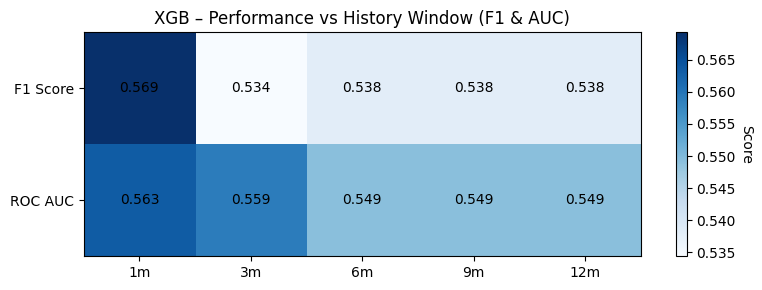

In [18]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

# --- we assume df_full + feature_cols already exist from previous cells ---

# 1) Build 1-hour future large-move label
future_ret = np.log(df_full["close"].shift(-1)) - np.log(df_full["close"])
df_full["future_abs"] = future_ret.abs()
df_full["threshold"]  = df_full["future_abs"].rolling(50).median()
df_full["y"] = (df_full["future_abs"] > df_full["threshold"]).astype(int)
df_full = df_full.dropna(subset=["y"])

# 2) History windows
history_windows = {
    "1m":  24*30,
    "3m":  24*90,
    "6m":  24*180,
    "9m":  24*270,
    "12m": 24*365,
}

results = []

TEST_SIZE = 500
df_test = df_full.iloc[-TEST_SIZE:]
X_test = df_test[feature_cols]
y_test = df_test["y"]

total_len = len(df_full)

# 3) Train & evaluate XGB for each history length
for label, hours in history_windows.items():
    usable_hours = min(hours, total_len - TEST_SIZE)
    start_idx = total_len - TEST_SIZE - usable_hours

    df_train = df_full.iloc[start_idx : total_len - TEST_SIZE]
    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = float(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "random_state": 42,
        "scale_pos_weight": spw,
        "n_estimators": 400,
        "max_depth": 3,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    results.append([label, usable_hours, f1, auc])

# 4) Results DF
results_df = pd.DataFrame(
    results,
    columns=["History Window", "Hours Used (actual)", "F1 Score", "ROC AUC"]
)

print(results_df)

# 5) Pretty matrix heatmap
windows = results_df["History Window"].tolist()
metric_matrix = np.vstack([
    results_df["F1 Score"].values,
    results_df["ROC AUC"].values
])

fig, ax = plt.subplots(figsize=(8,3))
im = ax.imshow(metric_matrix, cmap="Blues", aspect="auto")

ax.set_xticks(np.arange(len(windows)))
ax.set_xticklabels(windows)

ax.set_yticks([0,1])
ax.set_yticklabels(["F1 Score", "ROC AUC"])

# annotate
for i in range(metric_matrix.shape[0]):
    for j in range(metric_matrix.shape[1]):
        ax.text(
            j, i,
            f"{metric_matrix[i,j]:.3f}",
            ha="center", va="center",
            fontsize=10, color="black"
        )

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Score", rotation=270, labelpad=12)

plt.title("XGB – Performance vs History Window (F1 & AUC)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

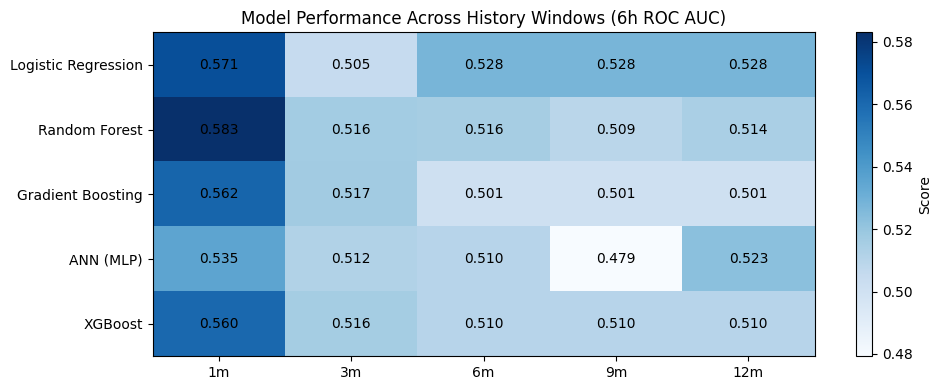

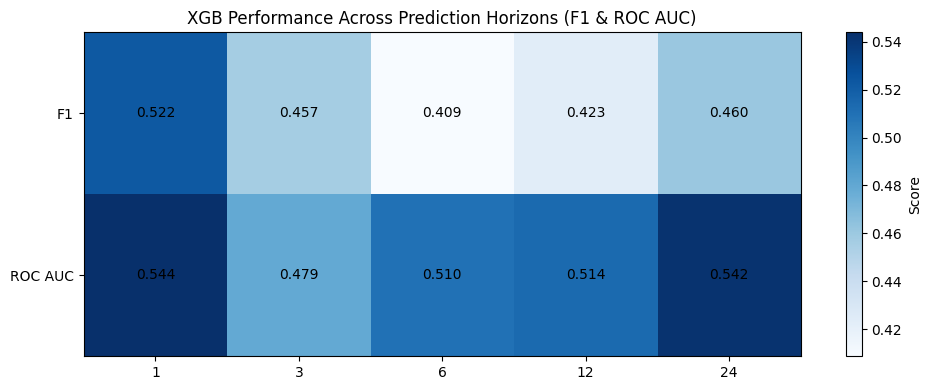

In [19]:
# ============================================
# MATRIX 1: MODELS × MONTH WINDOWS (6h horizon)
# MATRIX 2: XGB METRICS × PREDICTION HORIZONS
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

# ---------------------------------------------------------
# 1. Build feature DF + 6-hour future label for MATRIX 1
# ---------------------------------------------------------

df = merged_mkt.copy().sort_index()

# Features
df["coin_ret_1h"] = np.log(df["close"]) - np.log(df["close"].shift(1))
df["btc_ret_1h"]  = np.log(df["btc_close"]) - np.log(df["btc_close"].shift(1))
df["coin_ret_lag_1"] = df["coin_ret_1h"].shift(1)
df["coin_ret_lag_2"] = df["coin_ret_1h"].shift(2)
df["coin_ret_lag_3"] = df["coin_ret_1h"].shift(3)
df["btc_ret_lag_1"] = df["btc_ret_1h"].shift(1)
df["btc_ret_lag_2"] = df["btc_ret_1h"].shift(2)
df["coin_vol_6h"] = df["coin_ret_1h"].rolling(6).std()
df["btc_vol_6h"]  = df["btc_ret_1h"].rolling(6).std()
df["coin_minus_btc"] = df["coin_ret_1h"] - df["btc_ret_1h"]
df = df.dropna(subset=feature_cols)

# 6-hour future move label
H = 6
future_ret = np.log(df["close"].shift(-H)) - np.log(df["close"])
df["future_abs"] = future_ret.abs()
df["threshold"] = df["future_abs"].rolling(50).median()
df["y"] = (df["future_abs"] > df["threshold"]).astype(int)
df = df.dropna(subset=["y"])

# ---------------------------------------------------------
# HISTORY WINDOWS
# ---------------------------------------------------------
windows = {
    "1m": 24*30,
    "3m": 24*90,
    "6m": 24*180,
    "9m": 24*270,
    "12m": 24*365
}

TEST_SIZE = 500
df_test = df.iloc[-TEST_SIZE:]
X_test = df_test[feature_cols]
y_test = df_test["y"]
n_total = len(df)

# ---------------------------------------------------------
# MODELS (for matrix 1)
# ---------------------------------------------------------
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "Random Forest": RandomForestClassifier(n_estimators=400, max_depth=6),
    "Gradient Boosting": GradientBoostingClassifier(),
    "ANN (MLP)": Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(hidden_layer_sizes=(32,16), max_iter=300))
    ]),
    "XGBoost": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )
}

# ---------------------------------------------------------
# MATRIX 1: MODELS × WINDOWS (6h horizon)
# ---------------------------------------------------------

matrix1 = pd.DataFrame(index=models.keys(), columns=windows.keys())

for w_label, w_hours in windows.items():
    usable = min(w_hours, n_total - TEST_SIZE)
    df_train = df.iloc[n_total - TEST_SIZE - usable : n_total - TEST_SIZE]

    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    for name, model in models.items():
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, proba)
        matrix1.loc[name, w_label] = auc

# ---------------------------------------------------------
# MATRIX 2: XGB METRICS × HORIZONS
# ---------------------------------------------------------

horizons = [1, 3, 6, 12, 24]
matrix2 = pd.DataFrame(index=["F1", "ROC AUC"], columns=horizons)

for H in horizons:
    df_h = df.copy()
    future_ret = np.log(df_h["close"].shift(-H)) - np.log(df_h["close"])
    df_h["future_abs"] = future_ret.abs()
    df_h["threshold"] = df_h["future_abs"].rolling(50).median()
    df_h["y"] = (df_h["future_abs"] > df_h["threshold"]).astype(int)
    df_h = df_h.dropna(subset=["y"])

    df_test_h = df_h.iloc[-TEST_SIZE:]
    df_train_h = df_h.iloc[:-TEST_SIZE]

    X_train_h = df_train_h[feature_cols]
    y_train_h = df_train_h["y"]
    X_test_h = df_test_h[feature_cols]
    y_test_h = df_test_h["y"]

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )
    model.fit(X_train_h, y_train_h)

    preds = model.predict(X_test_h)
    proba = model.predict_proba(X_test_h)[:,1]

    matrix2.loc["F1", H] = f1_score(y_test_h, preds)
    matrix2.loc["ROC AUC", H] = roc_auc_score(y_test_h, proba)

# ---------------------------------------------------------
# DISPLAY BOTH MATRICES AS HEATMAPS
# ---------------------------------------------------------

def plot_heatmap(df, title, cmap="Blues"):
    plt.figure(figsize=(10,4))
    plt.imshow(df.astype(float), cmap=cmap, aspect="auto")
    plt.colorbar(label="Score")

    plt.xticks(range(df.shape[1]), df.columns)
    plt.yticks(range(df.shape[0]), df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            plt.text(j, i, f"{df.iloc[i,j]:.3f}", ha="center", va="center")

    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(matrix1, "Model Performance Across History Windows (6h ROC AUC)")
plot_heatmap(matrix2, "XGB Performance Across Prediction Horizons (F1 & ROC AUC)")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:43:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:43:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:43:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:43:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:44:04] WARNING: /w

                           1m        3m        6m        9m       12m
Logistic Regression  0.498361  0.524576  0.497834  0.497834  0.497834
Random Forest        0.453322  0.496756  0.512307  0.512307  0.512307
Gradient Boosting    0.472217  0.470754  0.502177  0.502177  0.502177
XGBoost              0.496462  0.482104  0.504710  0.504710  0.504710
ANN (MLP)            0.576704  0.518451  0.509430  0.509430  0.509430


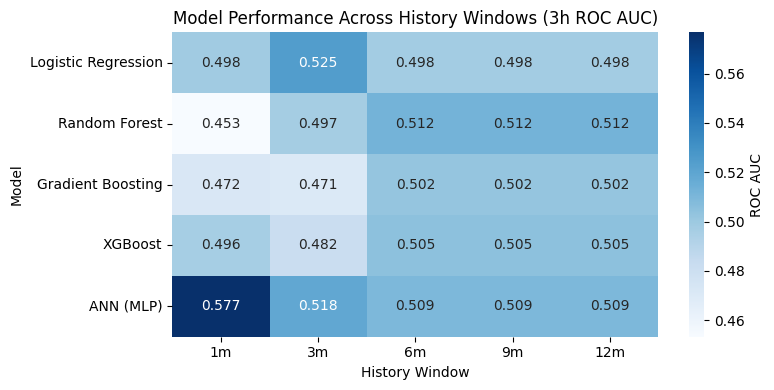

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb

# -------------------------------------------------------------------
# Assumes you already have merged_mkt with columns ['close','btc_close']
# If df + feature_cols already exist from earlier, you can skip this block
# -------------------------------------------------------------------
df = merged_mkt.copy().sort_index()

df["coin_ret_1h"] = np.log(df["close"]) - np.log(df["close"].shift(1))
df["btc_ret_1h"]  = np.log(df["btc_close"]) - np.log(df["btc_close"].shift(1))

df["coin_ret_lag_1"] = df["coin_ret_1h"].shift(1)
df["coin_ret_lag_2"] = df["coin_ret_1h"].shift(2)
df["coin_ret_lag_3"] = df["coin_ret_1h"].shift(3)

df["btc_ret_lag_1"] = df["btc_ret_1h"].shift(1)
df["btc_ret_lag_2"] = df["btc_ret_1h"].shift(2)

df["coin_vol_6h"] = df["coin_ret_1h"].rolling(6).std()
df["btc_vol_6h"]  = df["btc_ret_1h"].rolling(6).std()

df["coin_minus_btc"] = df["coin_ret_1h"] - df["btc_ret_1h"]

feature_cols = [
    "coin_ret_1h",
    "coin_ret_lag_1",
    "coin_ret_lag_2",
    "coin_ret_lag_3",
    "btc_ret_1h",
    "btc_ret_lag_1",
    "btc_ret_lag_2",
    "coin_vol_6h",
    "btc_vol_6h",
    "coin_minus_btc",
]

# -------------------------------------------------------------------
# Helper: train all models on a given history window for H = 3h
# -------------------------------------------------------------------
def eval_models_for_window(base_df, feature_cols, horizon_hours=3, threshold_window=50):
    df_h = base_df.copy()

    # 3h ahead log return + thresholding for "large move"
    df_h["future_ret_H"] = np.log(df_h["close"].shift(-horizon_hours)) - np.log(df_h["close"])
    df_h["future_abs_ret_H"] = df_h["future_ret_H"].abs()
    df_h["move_threshold_H"] = df_h["future_abs_ret_H"].rolling(threshold_window).median()
    df_h["y"] = (df_h["future_abs_ret_H"] > df_h["move_threshold_H"]).astype(int)

    df_h = df_h.dropna(subset=feature_cols + ["y"])

    X = df_h[feature_cols]
    y = df_h["y"].astype(int)

    n = len(df_h)
    if n < 500 or y.nunique() < 2:
        return {m: np.nan for m in ["Logistic Regression", "Random Forest",
                                    "Gradient Boosting", "XGBoost", "ANN (MLP)"]}

    # time-based split (same fractions as before)
    train_end = int(0.56 * n)
    val_end   = int(0.70 * n)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

    if y_train.nunique() < 2 or y_test.nunique() < 2:
        return {m: np.nan for m in ["Logistic Regression", "Random Forest",
                                    "Gradient Boosting", "XGBoost", "ANN (MLP)"]}

    results = {}

    # Logistic Regression
    logreg = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l2", C=1.0, max_iter=2000,
            class_weight="balanced", solver="lbfgs"
        )),
    ])
    logreg.fit(X_train, y_train)
    proba_lr = logreg.predict_proba(X_test)[:, 1]
    results["Logistic Regression"] = roc_auc_score(y_test, proba_lr)

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=500, max_depth=6,
        min_samples_leaf=20, max_features="sqrt",
        n_jobs=-1, random_state=42
    )
    rf.fit(X_train, y_train)
    proba_rf = rf.predict_proba(X_test)[:, 1]
    results["Random Forest"] = roc_auc_score(y_test, proba_rf)

    # Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05,
        max_depth=3, subsample=0.8, random_state=42
    )
    gb.fit(X_train, y_train)
    proba_gb = gb.predict_proba(X_test)[:, 1]
    results["Gradient Boosting"] = roc_auc_score(y_test, proba_gb)

    # XGBoost (simple tuned-ish config)
    pos = y_train.sum()
    neg = len(y_train) - pos
    scale_pos_weight = 1.0 if pos == 0 else neg / pos

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        tree_method="hist",
        scale_pos_weight=scale_pos_weight,
        n_estimators=600,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.9,
        gamma=0.0,
        reg_lambda=1.0,
        use_label_encoder=False,
    )
    xgb_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), verbose=False)
    proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    results["XGBoost"] = roc_auc_score(y_test, proba_xgb)

    # ANN / MLP
    ann = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(32, 16),
            activation="relu",
            solver="adam",
            alpha=1e-3,
            batch_size=64,
            learning_rate="adaptive",
            max_iter=300,
            random_state=42,
            shuffle=False,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.1,
        )),
    ])
    ann.fit(X_train, y_train)
    proba_ann = ann.predict_proba(X_test)[:, 1]
    results["ANN (MLP)"] = roc_auc_score(y_test, proba_ann)

    return results

# -------------------------------------------------------------------
# Evaluate 3h ROC AUC across history windows (1m, 3m, 6m, 9m, 12m)
# -------------------------------------------------------------------
history_windows_hours = {
    "1m": 24 * 30,
    "3m": 24 * 90,
    "6m": 24 * 180,
    "9m": 24 * 270,
    "12m": len(df),      # effectively "all history" / 1 year
}

model_names = ["Logistic Regression", "Random Forest",
               "Gradient Boosting", "XGBoost", "ANN (MLP)"]

results_mat = pd.DataFrame(index=model_names,
                           columns=list(history_windows_hours.keys()),
                           dtype=float)

for label, n_hours in history_windows_hours.items():
    n_hours = min(n_hours, len(df))
    df_win = df.iloc[-n_hours:].copy()
    scores = eval_models_for_window(df_win, feature_cols, horizon_hours=3)
    for m in model_names:
        results_mat.loc[m, label] = scores[m]

print(results_mat)

# -------------------------------------------------------------------
# Plot heatmap: Models vs Months (3h ROC AUC)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 4))
sns.heatmap(results_mat.astype(float),
            annot=True, fmt=".3f",
            cmap="Blues",
            cbar_kws={"label": "ROC AUC"})
plt.title("Model Performance Across History Windows (3h ROC AUC)")
plt.xlabel("History Window")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [21]:
from google.colab import files

df_full.to_csv("cleaned_data.csv", index=True)
files.download("cleaned_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# =============================================================
# Rebuild the exact table for the NEW 6H XGB model
# using ONLY 1-month of historical data for training.
# =============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import xgboost as xgb

# -----------------------------
# 1) Rebuild label for any horizon
# -----------------------------
def build_labels(df, H=6, threshold_window=50):
    df = df.copy()
    future_ret = np.log(df["close"].shift(-H)) - np.log(df["close"])
    df["future_abs"] = future_ret.abs()
    df["threshold"] = df["future_abs"].rolling(threshold_window).median()
    df["y"] = (df["future_abs"] > df["threshold"]).astype(int)
    return df.dropna(subset=["y"])

# -----------------------------
# 2) Function to train NEW XGB model on 1-month window
# -----------------------------
def train_xgb_1month(df, feature_cols, H):
    df_labeled = build_labels(df, H)

    TEST_SIZE = 500
    HOURS_1M = 24 * 30

    df_test = df_labeled.iloc[-TEST_SIZE:]
    df_train = df_labeled.iloc[-(TEST_SIZE + HOURS_1M):-TEST_SIZE]

    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    X_test = df_test[feature_cols]
    y_test = df_test["y"]

    # scale_pos_weight for class balance
    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = neg / pos if pos > 0 else 1.0

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        scale_pos_weight=spw
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)

    return auc, prec, rec

# -----------------------------
# 3) Build table across horizons
# -----------------------------

horizons = [1, 3, 6, 12]  # same as your slide
rows = []

for H in horizons:
    auc, prec, rec = train_xgb_1month(df_full, feature_cols, H)
    rows.append([f"{H}H", auc, prec, rec])

results_df = pd.DataFrame(rows, columns=["Horizon", "AUC", "Prec (1)", "Recall (1)"])
print(results_df)


  Horizon       AUC  Prec (1)  Recall (1)
0      1H  0.563345  0.520548    0.628099
1      3H  0.497934  0.450593    0.489270
2      6H  0.578997  0.546798    0.488987
3     12H  0.528870  0.471503    0.388889


  Horizon       AUC  Precision (1)  Recall (1)    F1 (1)
0      1H  0.562144       0.510511    0.702479  0.591304
1      3H  0.523493       0.477444    0.545064  0.509018
2      6H  0.591809       0.534483    0.273128  0.361516
3     12H  0.498522       0.439560    0.170940  0.246154


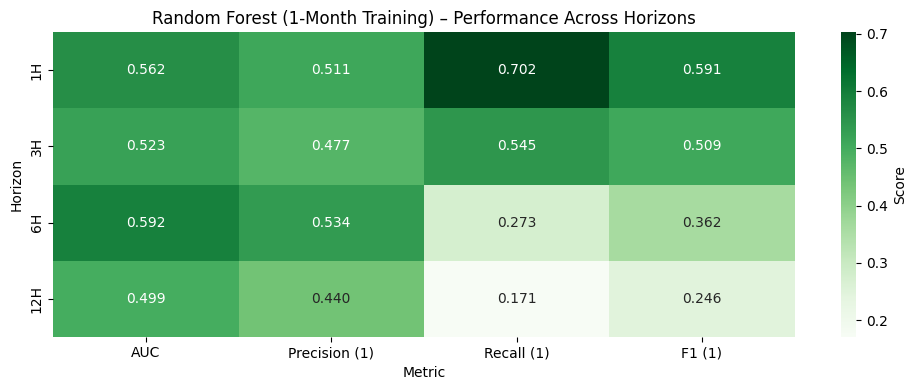

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

# -----------------------------------------------------
# Assumes df_full + feature_cols already exist in notebook
# -----------------------------------------------------

def build_labels(df, H=6, threshold_window=50):
    df = df.copy()
    future_ret = np.log(df["close"].shift(-H)) - np.log(df["close"])
    df["future_abs"] = future_ret.abs()
    df["threshold"] = df["future_abs"].rolling(threshold_window).median()
    df["y"] = (df["future_abs"] > df["threshold"]).astype(int)
    return df.dropna(subset=["y"])

def train_rf_1month(df, feature_cols, H):
    df_labeled = build_labels(df, H)

    TEST_SIZE = 500
    HOURS_1M = 24 * 30

    df_test = df_labeled.iloc[-TEST_SIZE:]
    df_train = df_labeled.iloc[-(TEST_SIZE + HOURS_1M):-TEST_SIZE]

    X_train = df_train[feature_cols]
    y_train = df_train["y"]

    X_test = df_test[feature_cols]
    y_test = df_test["y"]

    # Random Forest config
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=6,
        min_samples_leaf=20,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    proba = rf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    return auc, prec, rec, f1

# -----------------------------------------------------
# Evaluate RF for the horizons you used in your slide
# -----------------------------------------------------
horizons = [1, 3, 6, 12]
rows = []

for H in horizons:
    auc, prec, rec, f1 = train_rf_1month(df_full, feature_cols, H)
    rows.append([f"{H}H", auc, prec, rec, f1])

df_rf = pd.DataFrame(rows, columns=["Horizon", "AUC", "Precision (1)", "Recall (1)", "F1 (1)"])
print(df_rf)

# -----------------------------------------------------
# Beautiful heatmap visualization
# -----------------------------------------------------
plt.figure(figsize=(10, 4))
sns.heatmap(
    df_rf.set_index("Horizon").astype(float),
    annot=True,
    cmap="Greens",
    fmt=".3f",
    cbar_kws={"label": "Score"}
)

plt.title("Random Forest (1-Month Training) – Performance Across Horizons")
plt.xlabel("Metric")
plt.ylabel("Horizon")
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

# -----------------------------------------------------
# 1) Rebuild features from merged_mkt (if not already)
# -----------------------------------------------------
df_full = merged_mkt.copy().sort_index()

df_full["coin_ret_1h"] = np.log(df_full["close"]) - np.log(df_full["close"].shift(1))
df_full["btc_ret_1h"]  = np.log(df_full["btc_close"]) - np.log(df_full["btc_close"].shift(1))

df_full["coin_ret_lag_1"] = df_full["coin_ret_1h"].shift(1)
df_full["coin_ret_lag_2"] = df_full["coin_ret_1h"].shift(2)
df_full["coin_ret_lag_3"] = df_full["coin_ret_1h"].shift(3)

df_full["btc_ret_lag_1"] = df_full["btc_ret_1h"].shift(1)
df_full["btc_ret_lag_2"] = df_full["btc_ret_1h"].shift(2)

df_full["coin_vol_6h"] = df_full["coin_ret_1h"].rolling(6).std()
df_full["btc_vol_6h"]  = df_full["btc_ret_1h"].rolling(6).std()

df_full["coin_minus_btc"] = df_full["coin_ret_1h"] - df_full["btc_ret_1h"]

feature_cols = [
    "coin_ret_1h",
    "coin_ret_lag_1",
    "coin_ret_lag_2",
    "coin_ret_lag_3",
    "btc_ret_1h",
    "btc_ret_lag_1",
    "btc_ret_lag_2",
    "coin_vol_6h",
    "btc_vol_6h",
    "coin_minus_btc",
]

df_full = df_full.dropna(subset=feature_cols)

# -----------------------------------------------------
# 2) Build 1-hour future "large move" label (H = 1)
# -----------------------------------------------------
H = 1  # 1-hour horizon
future_ret = np.log(df_full["close"].shift(-H)) - np.log(df_full["close"])
df_full["future_abs"] = future_ret.abs()
df_full["threshold"] = df_full["future_abs"].rolling(50).median()
df_full["y"] = (df_full["future_abs"] > df_full["threshold"]).astype(int)

df_full = df_full.dropna(subset=["y"])

# -----------------------------------------------------
# 3) Use LAST 500 hours as test, PREVIOUS 1 month as train
# -----------------------------------------------------
TEST_SIZE = 500
HOURS_1M = 24 * 30

df_test = df_full.iloc[-TEST_SIZE:]
df_train = df_full.iloc[-(TEST_SIZE + HOURS_1M):-TEST_SIZE]

X_train = df_train[feature_cols]
y_train = df_train["y"].astype(int)

X_test = df_test[feature_cols]
y_test = df_test["y"].astype(int)

# -----------------------------------------------------
# 4) Train Random Forest (1-month training, 1h horizon)
# -----------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=20,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

preds = rf.predict(X_test)
proba = rf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Random Forest — 1h Horizon, 1-Month Training")
print(f"AUC:    {auc:.4f}")
print(f"Prec(1): {prec:.4f}")
print(f"Rec(1):  {rec:.4f}")
print(f"F1(1):   {f1:.4f}")


Random Forest — 1h Horizon, 1-Month Training
AUC:    0.5621
Prec(1): 0.5105
Rec(1):  0.7025
F1(1):   0.5913


In [25]:
# in your Colab notebook
from google.colab import files
import joblib

# df_full is your engineered feature dataframe
df_full.to_csv("cleaned_data.csv", index=True)

# rf is your final 1h, 1-month Random Forest model
joblib.dump(rf, "rf_model_1m_1h.pkl")

files.download("cleaned_data.csv")
files.download("rf_model_1m_1h.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import os
import shutil

# create folder if it doesn't exist
os.makedirs("final_demo", exist_ok=True)

# move files into folder
shutil.move("cleaned_data.csv", "final_demo/cleaned_data.csv")
shutil.move("rf_model_1m_1h.pkl", "final_demo/rf_model_1m_1h.pkl")

print("Files moved into final_demo/")


Files moved into final_demo/
